In [44]:
import re
import nltk
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
import warnings
from sklearn.metrics import classification_report

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/krypticmouse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/krypticmouse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [45]:
train = pd.read_csv('train.tsv', sep = '\t', na_values = '?')
train.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,1.0,1,24,0.0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,1.0,1,40,0.0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,1.0,1,55,0.0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,1.0,0,24,0.0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,1.0,1,14,0.0,12032,162,10,0.098765,0.082569,0


In [46]:
test = pd.read_csv('test.tsv', sep = '\t', na_values = '?')
test.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio
0,http://www.lynnskitchenadventures.com/2009/04/...,5865,"{""title"":""Homemade Enchilada Sauce Lynn s Kitc...",recreation,0.443906,2.558140,0.389706,0.257353,0.044118,0.022059,...,0.199438,1.0,1,15,0.0,5643,136,3,0.242647,0.080597
1,http://lolpics.se/18552-stun-grenade-ar,782,"{""title"":""lolpics Stun grenade ar "",""body"":"" f...",culture_politics,0.135844,3.771429,0.461538,0.205128,0.051282,0.000000,...,0.080000,NaN,1,62,0.0,382,39,2,0.128205,0.176471
2,http://www.xcelerationfitness.com/treadmills.html,6962,"{""title"":""Treadmills "",""body"":"" treadmills, st...",NaN,NaN,2.269565,0.495726,0.384615,0.170940,0.170940,...,10.000000,NaN,1,42,0.0,2420,117,1,0.581197,0.125000
3,http://www.bloomberg.com/news/2012-02-06/syria...,7640,"{""title"":""Father s Tactics Used by Assad to Cr...",culture_politics,0.902590,2.523490,0.705502,0.346278,0.122977,0.090615,...,0.005964,1.0,1,41,0.0,5559,309,10,0.038835,0.063126
4,http://www.wired.com/gadgetlab/2011/12/stem-tu...,3589,"{""title"":""Stem Turns Lemons and Limes Into Jui...",science_technology,0.486363,1.848000,0.470968,0.161290,0.032258,0.000000,...,0.035714,1.0,0,34,0.0,2209,155,10,0.096774,0.065341


# Data Exploration

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             7395 non-null   object 
 1   urlid                           7395 non-null   int64  
 2   boilerplate                     7395 non-null   object 
 3   alchemy_category                5053 non-null   object 
 4   alchemy_category_score          5053 non-null   float64
 5   avglinksize                     7395 non-null   float64
 6   commonlinkratio_1               7395 non-null   float64
 7   commonlinkratio_2               7395 non-null   float64
 8   commonlinkratio_3               7395 non-null   float64
 9   commonlinkratio_4               7395 non-null   float64
 10  compression_ratio               7395 non-null   float64
 11  embed_ratio                     7395 non-null   float64
 12  framebased                      73

**alchemy_category_score, news_front_page, is_news not in correct datatype**

In [48]:
train.isnull().sum()

url                                  0
urlid                                0
boilerplate                          0
alchemy_category                  2342
alchemy_category_score            2342
avglinksize                          0
commonlinkratio_1                    0
commonlinkratio_2                    0
commonlinkratio_3                    0
commonlinkratio_4                    0
compression_ratio                    0
embed_ratio                          0
framebased                           0
frameTagRatio                        0
hasDomainLink                        0
html_ratio                           0
image_ratio                          0
is_news                           2843
lengthyLinkDomain                    0
linkwordscore                        0
news_front_page                   1248
non_markup_alphanum_characters       0
numberOfLinks                        0
numwords_in_url                      0
parametrizedLinkRatio                0
spelling_errors_ratio    

In [49]:
train.describe()

,urlid,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
count,7395.000000,5053.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.0,...,4552.0,7395.000000,7395.000000,6147.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000
mean,5305.704665,0.603334,2.761823,0.468230,0.214080,0.092062,0.049262,2.255103,-0.103750,0.0,...,1.0,0.660311,30.077079,0.047828,5716.598242,178.754564,4.960649,0.172864,0.101221,0.513320
std,3048.384114,0.212864,8.619793,0.203133,0.146743,0.095978,0.072629,5.704313,0.306545,0.0,...,0.0,0.473636,20.393101,0.213420,8875.432430,179.466198,3.233111,0.183286,0.079231,0.499856
min,1.000000,0.070833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.0,...,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2688.500000,0.452424,1.602062,0.340370,0.105263,0.022222,0.000000,0.442616,0.000000,0.0,...,1.0,0.000000,14.000000,0.000000,1579.000000,82.000000,3.000000,0.040984,0.068739,0.000000
50%,5304.000000,0.625616,2.088235,0.481481,0.202454,0.068627,0.022222,0.483680,0.000000,0.0,...,1.0,1.000000,25.000000,0.000000,3500.000000,139.000000,5.000000,0.113402,0.089312,1.000000
75%,7946.500000,0.780851,2.627451,0.616604,0.300000,0.133333,0.065065,0.578227,0.000000,0.0,...,1.0,1.000000,43.000000,0.000000,6377.000000,222.000000,7.000000,0.241299,0.112376,1.000000
max,10566.000000,0.999426,363.000000,1.000000,1.000000,0.980392,0.980392,21.000000,0.250000,0.0,...,1.0,1.000000,100.000000,1.000000,207952.000000,4997.000000,22.000000,1.000000,1.000000,1.000000


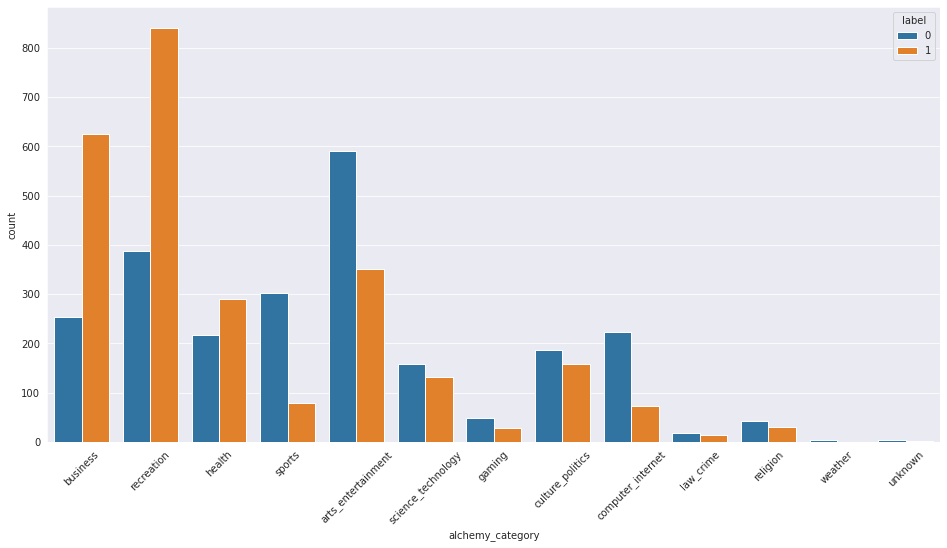

In [50]:
plt.figure(figsize = (16,8))
sns.countplot(x = train['alchemy_category'], hue = train['label'])
plt.xticks(rotation = 45)
plt.show()

* Sports, computer_internet,arts_entertainment,weather seems to be more likely to be non evergreen
* business, recreation are more likely to be evergreen than non evergreen

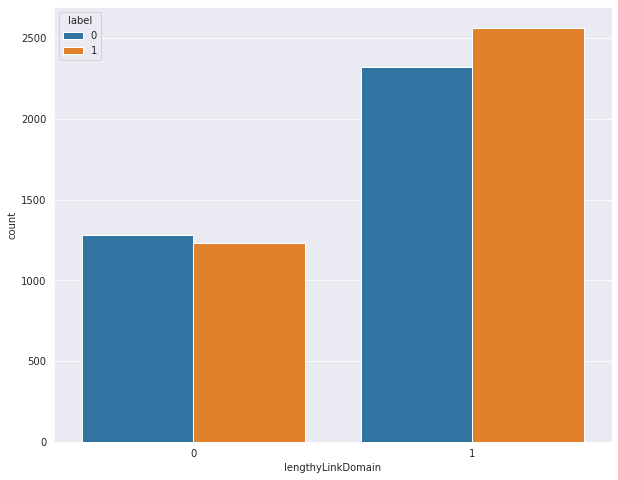

In [51]:
plt.figure(figsize = (10,8))
sns.countplot(x = train['lengthyLinkDomain'], hue = train['label'])
plt.show()

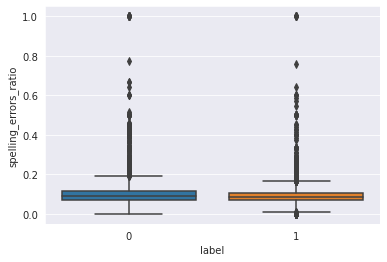

In [52]:
sns.boxplot(data=train, x = 'label', y = 'spelling_errors_ratio')

In [53]:
#px.box(data_frame=train, x = 'label', y = 'image_ratio')

# Data Preprocessing

In [54]:
def preprocess(df):
    stop = set(stopwords.words('english'))
    X = []
    df = df.apply(lambda x:' '.join([x for x in json.loads(x).values() if x is not None]).lower())
    stemmer = PorterStemmer()
    
    for sent in tqdm(df):
        text = re.sub(r'[^a-zA-Z ]+', ' ', sent).strip()
        token = word_tokenize(text.lower())
        token = [stemmer.stem(i) for i in token if i not in stop]
        text = ' '.join(token)
        X.append(text)
    return X

In [55]:
X = preprocess(train['boilerplate'])
Y = train['label']

In [56]:
x_test = preprocess(test['boilerplate'])

In [57]:
tfidf = TfidfVectorizer(min_df = 0.01)
embeds = tfidf.fit_transform(X).toarray()

In [58]:
test_embeds = tfidf.transform(x_test).toarray()

# Model Training

In [59]:
clf = XGBClassifier(use_label_encoder=False, eval_metric = "logloss")
scores = cross_validate(clf, embeds, Y, cv=3, scoring=['roc_auc','precision','recall'], verbose = 100)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  ................................................................
[CV] ... , precision=0.829, recall=0.737, roc_auc=0.847, total=   8.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s
[CV]  ................................................................
[CV] ... , precision=0.832, recall=0.766, roc_auc=0.864, total=   7.8s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s
[CV]  ................................................................
[CV] ... , precision=0.840, recall=0.742, roc_auc=0.862, total=   7.8s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.9s finished


In [60]:
scores

{'fit_time': array([8.15184379, 7.72612476, 7.71141315]),
 'score_time': array([0.09860468, 0.09698629, 0.09668136]),
 'test_roc_auc': array([0.84694401, 0.86350823, 0.86156908]),
 'test_precision': array([0.82918149, 0.83175966, 0.84003575]),
 'test_recall': array([0.73675889, 0.76600791, 0.74249605])}

In [61]:
clf.fit(embeds,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [62]:
print(classification_report(Y, clf.predict(embeds)))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3599
           1       0.97      0.90      0.93      3796

    accuracy                           0.93      7395
   macro avg       0.94      0.94      0.93      7395
weighted avg       0.94      0.93      0.93      7395



In [63]:
y_preds = clf.predict(test_embeds)

In [64]:
pd.DataFrame({'urlid':test['urlid'],'label':y_preds}).to_csv('submit.csv', index=False)